In [1]:
import numpy as np
import pandas as pd 
import geopandas as gpd
import hvplot as hv
import hvplot.pandas
import sys, os
import pickle
import matplotlib.pyplot as plt
project_root = os.path.abspath(os.path.join(os.getcwd(), '../..'))  # parent of notebooks
if project_root not in sys.path:
    sys.path.append(project_root)
    
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.metrics import accuracy_score,balanced_accuracy_score, confusion_matrix, ConfusionMatrixDisplay, root_mean_squared_error, mean_absolute_error, mean_squared_error

from src.util.model import eval_model, prep_data
seed = 42

In [49]:
# dff0 = pd.DataFrame()

# data_fp = "../../data/training_data"
# training_data = os.listdir(data_fp)
# for i in range(len(training_data)):
#     # if i > 4: 
#     #     break
#     fn = training_data[i]
#     df = pd.read_csv(os.path.join(data_fp, fn))
#     print(f"{fn} {df.shape}")
#     dff0 = pd.concat([dff0, df])
# print(dff0.shape)

dff0 = pd.read_csv("../../data/training_combined/training_combined_2.csv")

danger_levels = pd.read_csv("../../../data/FAC/FAC_Danger_rating_zone_elv.csv")
danger_levels['date'] = pd.to_datetime(danger_levels['date'])

coords_geodf = gpd.read_file("../../../data/FAC/zones/grid_coords_subset.geojson")

In [50]:
exclude_cols = ['date','id_x','slope_azi', 'danger_level','altitude','slope_angle','elevation_band','lat', 'lon', 'zone_name', 'geometry']
# X, y, excluded_cols = prep_data(
#     dff0, 
#     danger_levels, 
#     coords_geodf,
#     replace_missing=True, 
#     change_danger=True,
#     exclude_cols=['date','id','id_x','slope_azi', 'danger_level','altitude','slope_angle','forecast_zone_id','elevation_band','lat', 'lon', 'zone_name', 'geometry']) 

X = dff0.loc[:, ~dff0.columns.isin(exclude_cols)].copy(deep=True)
y = dff0['danger_level']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=seed)

In [51]:
# Params found from tuning
# {'class_weight': 'balanced', 
#  'max_depth': 50, 
#  'max_features': 0.5, 
#  'min_samples_leaf': 4, 
#  'min_samples_split': 20, 
#  'n_estimators': 1000}


rf = RandomForestClassifier(random_state=seed, n_jobs=-1,
                            max_depth=50,
                            max_features=0.5,
                            min_samples_leaf=4,
                            min_samples_split=20,
                            n_estimators=500,
                            class_weight='balanced'
                           )

# with open("../../data/models/best_model.pkl", "rb") as file:
#     rf = pickle.load(file)

In [13]:
cv = cross_val_score(rf, X_train,y_train,cv=5,n_jobs=-1)

In [24]:
for c in cv:
    print(f"{c * 100:.2f} ", end="")
print()
print(f"CV Results: Mean Accuracy - {cv.mean():.2f}% std - {cv.std():.2f}")

90.51 90.70 90.03 90.39 90.30 
CV Results: Mean Accuracy - 0.90% std - 0.00


In [8]:
rf.fit(X_train, y_train)

,n_estimators,500
,criterion,'gini'
,max_depth,50
,min_samples_split,20
,min_samples_leaf,4
,min_weight_fraction_leaf,0.0
,max_features,0.5
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


Train
Accuracy 0.99
Balanced Accuracy 0.99
MAE: 0.016656162780228686
Test
Accuracy 0.93
Balanced Accuracy 0.94
MAE: 0.0777287596410672


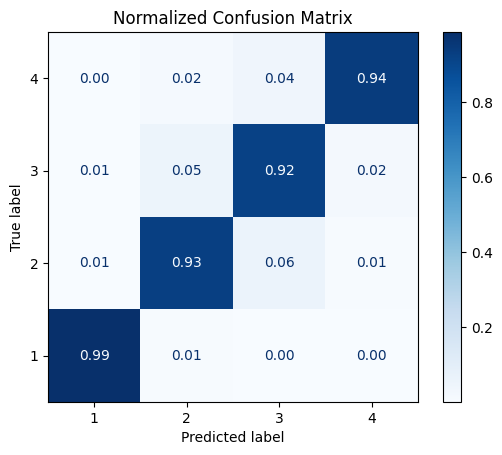

In [47]:
y_pred = rf.predict(X_test)

print("Train")
eval_model(y_train, rf.predict(X_train))

print("Test")
eval_model(y_test, y_pred, plot=True, norm=True)

In [ ]:
test_data = pd.concat([X_test,dff0[exclude_cols].iloc[X_test.index]],axis=1)
# test_data = pd.concat([X_test,excluded_cols.iloc[X_test.index]],axis=1)
test_data['predicted'] = y_pred
test_data.head()

,Qs,Ql,Qg,TSG,Qg0,Qr,dIntEnergySnow,meltFreezeEnergySnow,ColdContentSnow,OLWR,...,slope_azi,date,altitude,lat,lon,zone_name,geometry,elevation_band,danger_level,predicted
83977,20.478292,-13.475500,0.0,0.000000,-6.415042,0.000000,34.809333,34.809333,-0.021833,298.679542,...,0.0,2021-03-15,1604.9,48.549201,-114.361584,whitefish,POINT (-114.36158 48.5492),middle,2,2
107653,84.158792,-5.476458,0.0,-1.211042,-2.542417,0.029875,-50.008333,-50.008250,-0.062833,294.213208,...,270.0,2025-03-27,2259.6,48.620467,-113.769500,flathead,POINT (-113.7695 48.62047),upper,3,3
67548,38.821458,-13.086208,0.0,-1.689708,2.278375,0.000458,1.461333,-0.065792,-0.959250,290.641167,...,0.0,2020-12-20,1551.4,48.542347,-114.196594,whitefish,POINT (-114.19659 48.54235),middle,3,3
67416,-4.683667,-9.657167,0.0,-15.814958,-4.624292,0.000000,3.584292,3.001292,-2.880292,245.305667,...,0.0,2025-01-28,1551.4,48.542347,-114.196594,whitefish,POINT (-114.19659 48.54235),middle,1,1
29885,14.238667,4.408000,0.0,-1.411458,2.160667,0.000000,26.003500,4.130708,-1.199750,284.617250,...,270.0,2024-04-05,1864.4,48.316792,-114.053157,swan,POINT (-114.05316 48.31679),middle,1,1


In [41]:
feature_importances = pd.DataFrame(rf.feature_importances_,index = rf.feature_names_in_, columns=["importance"]).sort_values(by="importance", ascending=False)
print(feature_importances[feature_importances['importance'] > 0].index)

Index(['mAlbedo', 'TA', 'ISWR_diff', 'ISWR_h', 'HN72_24', 'RH', 'wind_trans24',
       'SWE', 'DW', 'T_bottom', 'PSUM24', 'TSG', 'VW_drift', 'VW', 'ILWR',
       'ColdContentSnow', 'HN24', 'dIntEnergySnow', 'OLWR', 'MS_Sublimation',
       'ski_pen', 'TSS_mod', 'LWR_net', 'Qg0', 'HN3', 'HS_mod', 'MS_Snow',
       'Qs', 'HN6', 'pAlbedo', 'HN12', 'Ql', 'MS_Evap', 'S4', 'Sd', 'Sclass2',
       'MS_Rain', 'zSn', 'zSd', 'Ss', 'HS_meas', 'zSs', 'meltFreezeEnergySnow',
       'zS4', 'OSWR', 'Qr', 'ISWR', 'Qw', 'S5', 'Sn', 'MS_Water', 'hoar_size',
       'ISWR_dir', 'MS_Surface_Mass_Flux', 'MS_SN_Runoff', 'MS_Wind'],
      dtype='object')


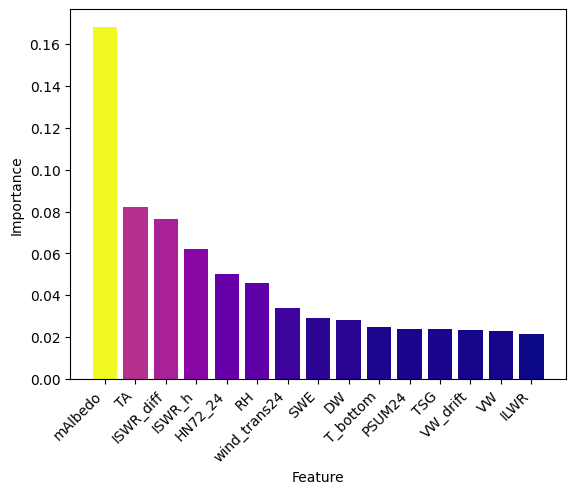

In [42]:
top = feature_importances.iloc[:15]
 
# Normalize and create colors
norm = plt.Normalize(top['importance'].min(), top['importance'].max())
cmap = plt.cm.plasma
colors = cmap(norm(top['importance']))

# Create figure and axes
fig, ax = plt.subplots()

bars = ax.bar(top.index, top['importance'], color=colors)

# Add colorbar — note the ax parameter
sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])  # Required for colorbar
# fig.colorbar(sm, ax=ax, label='Importance')
plt.xticks(rotation=45, ha='right')
plt.ylabel("Importance")
plt.xlabel("Feature")
plt.show()

Train
Accuracy 0.99
Balanced Accuracy 0.99
MAE: 0.016656162780228686
Test
Accuracy 0.93
Balanced Accuracy 0.94
MAE: 0.0777287596410672


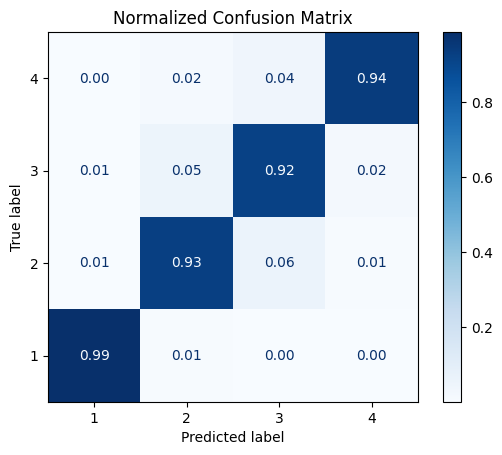

In [43]:

with open("../../data/models/best_model_2.pkl", "ab") as file:
    pickle.dump(rf, file)
    
with open("../../data/models/best_model_2.pkl", "rb") as file:
    best_model = pickle.load(file)
    
y_pred = best_model.predict(X_test)

print("Train")
eval_model(y_train, best_model.predict(X_train))

print("Test")
eval_model(y_test, y_pred, plot=True, norm=True)